In [240]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import re
# import nltk
# from nltk.corpus import  stopwords
# from nltk.tokenize import  word_tokenize

In [241]:
# تحميل البيانات 
df = pd.read_csv("IMDB Dataset.csv") 

In [242]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [243]:
df.shape

(50000, 2)

In [244]:
print(df.isnull().sum())


review       0
sentiment    0
dtype: int64


In [245]:
# تنظيف النصوص
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

In [246]:
# 1. تحويل النص إلى ميزات رقمية باستخدام TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # حذف الكلمات الشائعة واختيار 5000 ميزة
X = vectorizer.fit_transform(df['cleaned_review'])  # تحويل النصوص إلى تمثيل رقمي

In [247]:
# تقليل الأبعاد باستخدام PCA قبل تدريب K-Means
pca = PCA(n_components=100)  # اختيار 100 مكونًا
X_pca = pca.fit_transform(X.toarray())

In [248]:
# اختبار القيم المثلى لعدد المجموعات K باستخدام طريقة Elbow Method و Silhouette Score
wcss = []  # تخزين مجموع التباين داخل المجموعات
K_range = range(2, 11)  # تجربة القيم من 2 إلى 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

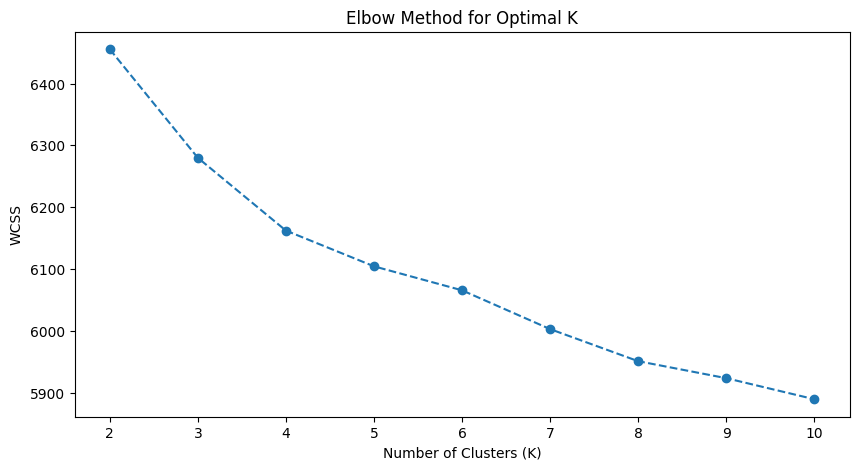

In [249]:
# رسم مخطط Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

In [250]:
from kneed import KneeLocator  # مكتبة لتحديد نقطة الكوع تلقائيًا

# إيجاد نقطة Elbow تلقائيًا
knee = KneeLocator(K_range, wcss, curve="convex", direction="decreasing")
optimal_k = knee.elbow
optimal_k

np.int64(4)

In [251]:
# تطبيق K-Means باستخدام K المثالية
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X_pca)
df['Cluster'] = kmeans.labels_

In [252]:
# حساب Silhouette Score النهائي بعد PCA
final_silhouette_score = silhouette_score(X_pca, kmeans.labels_)
print(f"Silhouette Score النهائي بعد PCA والتجميع: {final_silhouette_score:.4f}")

Silhouette Score النهائي بعد PCA والتجميع: 0.0268


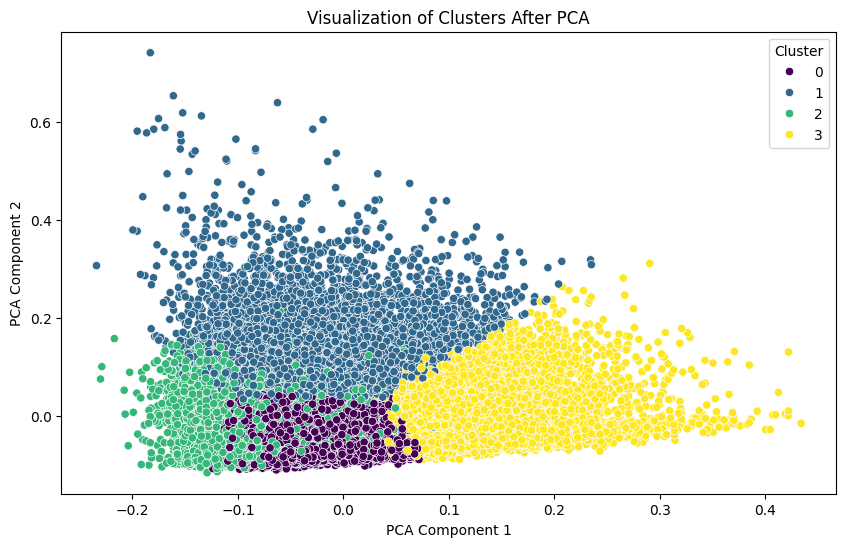

In [253]:
# تقليل الأبعاد إلى 2D فقط للتصور
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X.toarray())

df['PCA1'] = X_pca_2d[:, 0]
df['PCA2'] = X_pca_2d[:, 1]

# رسم النقاط في 2D بعد PCA والتجميع
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['PCA1'], y=df['PCA2'], hue=df['Cluster'], palette='viridis')
plt.title("Visualization of Clusters After PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()